In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('seaborn-paper')
import seaborn as sns
import joblib

# plt.rcParams['font.family']='Times New Roman,Microsoft YaHei'# 设置字体族，中文为微软雅黑，英文为Times New Roman
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'  # 设置数学公式字体为stix
plt.rcParams["text.usetex"] = False
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

C:\Users\aa271\AppData\Local\Temp\ipykernel_18860\3220340077.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-paper')


In [2]:
datajh = pd.read_csv("groupedjh.csv")
datacm = pd.read_csv("groupedcm.csv")

In [3]:
# External packages
import torch
# Internal code import
import physo
from physo.learn import monitoring
from physo.task  import benchmark

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because having a CUDA-able version of pytorch was found to cause issues on some systems (even if the dataset is sent to the proper device). Please install the vanilla non CUDA-able version of pytorch via conda install pytorch (returning torch.cuda.is_available() = False) to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because having a CUDA-able version of pytorch was found to cause issues on some systems (even if the dataset is sent to the proper device). Please install the vanilla non CUDA-able version of pytorch via conda 

F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:192: UserWarning: Parallel mode is not available because having a CUDA-able version of pytorch was found to cause issues on some systems (even if the dataset is sent to the proper device). Please install the vanilla non CUDA-able version of pytorch via conda install pytorch (returning torch.cuda.is_available() = False) to use parallel mode.
  warnings.warn(msg)
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [4]:
# Device
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'
print(DEVICE)

cuda


In [5]:
data=datajh[(datajh["Season"]=="Summer")].groupby(["Hour_Min"]).mean().reset_index()
X_=data[["O3","NOx","SO2","异戊二烯浓度","地面层温度","地面层净辐射","地面层湿度"]]
y_=data["PM1"]

C:\Users\aa271\AppData\Local\Temp\ipykernel_18860\2730368618.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=datajh[(datajh["Season"]=="Summer")].groupby(["Hour_Min"]).mean().reset_index()


In [6]:
name=["O3","NOx","SO2","BVOCs","T","R","H"]

In [7]:
# ------ Vectors ------
# Stack of all input variables
X = torch.tensor(np.array(X_).reshape(X_.shape[1],-1)).to(DEVICE)
# Output of symbolic function to guess
y = torch.tensor(np.array(y_)).to(DEVICE)
# ------ Constants ------
const1 = torch.tensor(np.array(1.)).to(DEVICE)

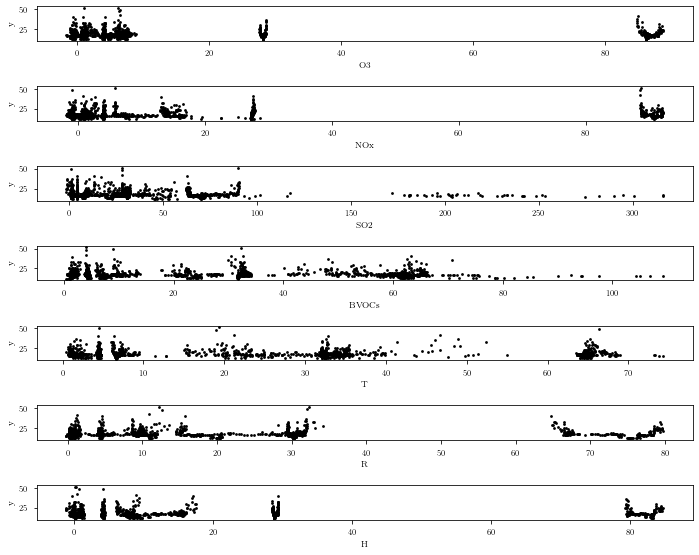

In [8]:
n_dim = np.array(X_).reshape(X_.shape[1],-1).shape[0]
fig, ax = plt.subplots(n_dim, 1, figsize=(10,8))
for i in range (n_dim):
    curr_ax = ax if n_dim==1 else ax[i]
    curr_ax.plot(np.array(X_).reshape(X_.shape[1],-1)[i], np.array(y_), 'k.',)
    curr_ax.set_xlabel(name[i])
    curr_ax.set_ylabel("y")

plt.tight_layout()
plt.show()

In [9]:
# Choosing a [length, time, mass, mol, K] convention for this run
args_make_tokens = {
                # operations
                "op_names"             : ["mul", "add", "sub", "div", "inv", "n2", "sqrt", "exp", "log", "sin", "cos"],
                "use_protected_ops"    : True,
                # input variables
                "input_var_ids"        : {"O" : 0 , "NOx" : 1 , "SO" : 2  , "BVOCs" : 3  ,"T" : 4 ,"R":5,"H":6},
                # "input_var_units"      : {"O3" : [1,-3,0,0,0] , "NOx" : [1,-3,0,0,0] , "SO2" : [1,-3,0,0,0]  , "BVOCs" : [1,-3,0,0,0] ,"T" : [0,0,1,0,0],"R":[0,0,0,1,0],"H":[0,0,0,0,1] },
                 "input_var_units"      : {"O" : [0,0,0] , "NO" : [0,0,0] , "SO" : [0,0,0]  , "BVOCs" : [0,0,0] ,"T" : [0,0,0],"R":[0,0,0],"H":[0,0,0] },
                "input_var_complexity" : {"O" : 1., "NOx" : 1. , "SO" : 1., "BVOCs" :  1.,"T" :  1.,"R": 1.,"H": 1.},
                # constants
                "constants"            : {"1" : const1          , },
                "constants_units"      : {"1" : [0,0,0] , },
                "constants_complexity" : {"1" : 1.              , },
                # free constants
                "free_constants"            : {"a"                      , "b"                   , "c"                   },
                "free_constants_units"      : {"a" : [0, 0, 0]  , "b" : [0, 0, 0] ,"c" : [0, 0, 0]},
                "free_constants_init_val"   : {"a" : 1.                 , "b" : 1.              , "c" : 1.                         },
                "free_constants_complexity" : {"a" : 1.                 , "b" : 1.              , "c" : 1.                   },
                    }

library_config = {"args_make_tokens"  : args_make_tokens,
                  "superparent_units" : [0,0,0] ,
                  "superparent_name"  : "SOA",
                }

In [10]:
reward_config = {
                 "reward_function"     : physo.physym.reward.SquashedNRMSE, # PHYSICALITY
                 "zero_out_unphysical" : True,
                 "zero_out_duplicates" : False,
                 "keep_lowest_complexity_duplicate" : False,
                 "parallel_mode" : True,
                 "n_cpus"        : None,
                }

In [11]:
BATCH_SIZE = int(1e4)
MAX_LENGTH = 35
GET_OPTIMIZER = lambda model : torch.optim.Adam(
                                    model.parameters(),
                                    lr=0.0025, #0.001, #0.0050, #0.0005, #1,  #lr=0.0025
                                                )

In [12]:
learning_config = {
    # Batch related
    'batch_size'       : BATCH_SIZE,
    'max_time_step'    : MAX_LENGTH,
    'n_epochs'         : int(1e9),
    # Loss related
    'gamma_decay'      : 0.7,
    'entropy_weight'   : 0.005,
    # Reward related
    'risk_factor'      : 0.05,
    'rewards_computer' : physo.physym.reward.make_RewardsComputer (**reward_config),
    # Optimizer
    'get_optimizer'    : GET_OPTIMIZER,
    'observe_units'    : True,
}

Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because having a CUDA-able version of pytorch was found to cause issues on some systems (even if the dataset is sent to the proper device). Please install the vanilla non CUDA-able version of pytorch via conda install pytorch (returning torch.cuda.is_available() = False) to use parallel mode.
Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
Parallel mode is not available because having a CUDA-able version of pytorch was found to cause issues on some systems (even if the dataset is sent to the proper device). Please install the vanilla non CUDA-able version of pytorch via conda 

F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:182: UserWarning: Parallel mode is not available because physo is being ran from a notebook on a system returning multiprocessing.get_start_method() = 'spawn' (typically MACs/Windows). Run physo from the terminal to use parallel mode.
  warnings.warn(msg)
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:192: UserWarning: Parallel mode is not available because having a CUDA-able version of pytorch was found to cause issues on some systems (even if the dataset is sent to the proper device). Please install the vanilla non CUDA-able version of pytorch via conda install pytorch (returning torch.cuda.is_available() = False) to use parallel mode.
  warnings.warn(msg)
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\reward.py:229: UserWarning: Parallel mode is not available on this system, switching to non parallel mode.
  warnings.warn("Parallel mode is not available on this system, switching to non parallel mode.")


In [13]:
free_const_opti_args = {
            'loss'   : "MSE",
            'method' : 'LBFGS',
            'method_args': {
                        'n_steps' : 15,
                        'tol'     : 1e-8,
                        'lbfgs_func_args' : {
                            'max_iter'       : 4,
                            'line_search_fn' : "strong_wolfe",
                                             },
                            },
        }

In [14]:
priors_config  = [
                #("UniformArityPrior", None),
                # LENGTH RELATED
                ("HardLengthPrior"  , {"min_length": 8, "max_length": MAX_LENGTH, }),
                ("SoftLengthPrior"  , {"length_loc": 12, "scale": 5, }),
                # RELATIONSHIPS RELATED
                ("NoUselessInversePrior"  , None),
                ("PhysicalUnitsPrior", {"prob_eps": np.finfo(np.float32).eps}), # PHYSICALITY
                ("NestedFunctions", {"functions":["exp",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["log",], "max_nesting" : 1}),
                ("NestedFunctions", {"functions":["cos","sin", "log", "exp",], "max_nesting" : 1}),
                ("NestedTrigonometryPrior", {"max_nesting" : 1}),
                #("OccurrencesPrior", {"targets" : ["1",], "max" : [3,] }),
                 ]

In [15]:
cell_config = {
    "hidden_size" : 128,
    "n_layers"    : 1,
    "is_lobotomized" : False,
}

In [16]:
save_path_training_curves = 'demo_curves.png'
save_path_log             = 'demo.log'

run_logger     = monitoring.RunLogger(save_path = save_path_log,
                                      do_save = True)

run_visualiser = monitoring.RunVisualiser (epoch_refresh_rate = 5,
                                           save_path = save_path_training_curves,
                                           do_show   = False,
                                           do_prints = True,
                                           do_save   = True, )

In [17]:
run_config = {
    "learning_config"      : learning_config,
    "reward_config"        : reward_config,
    "free_const_opti_args" : free_const_opti_args,
    "library_config"       : library_config,
    "priors_config"        : priors_config,
    "cell_config"          : cell_config,
    "run_logger"           : run_logger,
    "run_visualiser"       : run_visualiser,
}

In [ ]:
benchmark.dummy_epoch(X, y, run_config)

F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\functions.py:404: UserWarning: Physical units of token NOx not found in units dictionary {'O': [0, 0, 0], 'NO': [0, 0, 0], 'SO': [0, 0, 0], 'BVOCs': [0, 0, 0], 'T': [0, 0, 0], 'R': [0, 0, 0], 'H': [0, 0, 0]}, assuming it is                 dimensionless ie units=[0. 0. 0. 0. 0. 0. 0.]
  warnings.warn(
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:493: UserWarning: Unable to optimize free constants of prog [sub b n2 cos div b sqrt sqrt 1] -> r = 0
  warnings.warn("Unable to optimize free constants of prog %s -> r = 0" % (str(prog)))
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:493: UserWarning: Unable to optimize free constants of prog [exp sqrt sqrt mul sqrt c add b n2 BVOCs] -> r = 0
  warnings.warn("Unable to optimize free constants of prog %s -> r = 0" % (str(prog)))
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:493: UserWarning: Unable to optimize free constants of prog [inv sub n2 div exp sub O c log T mul sub O c H] -> r = 0

In [ ]:
rewards, candidates = physo.fit (X, y, run_config,
                                stop_reward = 0.9999,
                                stop_after_n_epochs = 5)

F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\functions.py:404: UserWarning: Physical units of token NOx not found in units dictionary {'O': [0, 0, 0], 'NO': [0, 0, 0], 'SO': [0, 0, 0], 'BVOCs': [0, 0, 0], 'T': [0, 0, 0], 'R': [0, 0, 0], 'H': [0, 0, 0]}, assuming it is                 dimensionless ie units=[0. 0. 0. 0. 0. 0. 0.]
  warnings.warn(


Unable to save pareto figure.
=========== Epoch 00000 ===========
-> Time 50.29 s

Overall best  at R=0.504217
Unable to print status.


F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\functions.py:404: UserWarning: Physical units of token NOx not found in units dictionary {'O': [0, 0, 0], 'NO': [0, 0, 0], 'SO': [0, 0, 0], 'BVOCs': [0, 0, 0], 'T': [0, 0, 0], 'R': [0, 0, 0], 'H': [0, 0, 0]}, assuming it is                 dimensionless ie units=[0. 0. 0. 0. 0. 0. 0.]
  warnings.warn(


=========== Epoch 00001 ===========
-> Time 2081.52 s

Overall best  at R=0.504768
Unable to print status.


F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\functions.py:404: UserWarning: Physical units of token NOx not found in units dictionary {'O': [0, 0, 0], 'NO': [0, 0, 0], 'SO': [0, 0, 0], 'BVOCs': [0, 0, 0], 'T': [0, 0, 0], 'R': [0, 0, 0], 'H': [0, 0, 0]}, assuming it is                 dimensionless ie units=[0. 0. 0. 0. 0. 0. 0.]
  warnings.warn(


=========== Epoch 00002 ===========
-> Time 1808.06 s

Overall best  at R=0.504768
Unable to print status.


F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\functions.py:404: UserWarning: Physical units of token NOx not found in units dictionary {'O': [0, 0, 0], 'NO': [0, 0, 0], 'SO': [0, 0, 0], 'BVOCs': [0, 0, 0], 'T': [0, 0, 0], 'R': [0, 0, 0], 'H': [0, 0, 0]}, assuming it is                 dimensionless ie units=[0. 0. 0. 0. 0. 0. 0.]
  warnings.warn(
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:493: UserWarning: Unable to optimize free constants of prog [cos sqrt mul sqrt R div sqrt sub mul 1 inv c c div BVOCs c] -> r = 0
  warnings.warn("Unable to optimize free constants of prog %s -> r = 0" % (str(prog)))
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:493: UserWarning: Unable to optimize free constants of prog [cos n2 n2 sub div R 1 n2 c] -> r = 0
  warnings.warn("Unable to optimize free constants of prog %s -> r = 0" % (str(prog)))
F:\作业文件\BVOC-SOA\CI\随机建模分析\physo\physym\execute.py:493: UserWarning: Unable to optimize free constants of prog [n2 sin inv mul sub 1 c add a mul sqrt BVO

In [ ]:
run_visualiser.make_visualisation()
run_visualiser.save_visualisation()
run_visualiser.save_data()

In [ ]:
2

In [ ]:
def plot_pareto_front(run_logger,
                      do_simplify                   = True,
                      show_superparent_at_beginning = True,
                      eq_text_size                  = 12,
                      delta_xlim                    = [0, 5 ],
                      delta_ylim                    = [0, 15],
                      frac_delta_equ                = [0.03, 0.03],
                      figsize                       = (20, 10),
                     ):

    pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

    pareto_front_rmse = pareto_front_rmse
    # Fig params
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')
    # enables new_dummy_symbol = "\square"
    plt.rc('text.latex', preamble=r'\usepackage{amssymb} \usepackage{xcolor}')
    plt.rc('font', size=32)

    # Fig
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'r-')
    ax.plot(pareto_front_complexities, pareto_front_rmse, 'ro')

    # Limits
    xmin = pareto_front_complexities.min() + delta_xlim[0]
    xmax = pareto_front_complexities.max() + delta_xlim[1]
    ymin = pareto_front_rmse.min() + delta_ylim[0]
    ymax = pareto_front_rmse.max() + delta_ylim[1]
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    # Axes labels
    ax.set_xlabel("Expression complexity")
    ax.set_ylabel("RMSE")


    for i_prog in range (len(pareto_front_programs)):
        prog = pareto_front_programs[i_prog]

        text_pos  = [pareto_front_complexities[i_prog] + frac_delta_equ[0]*(xmax-xmin),
                     pareto_front_rmse[i_prog]         + frac_delta_equ[1]*(ymax-ymin)]
        # Getting latex expr
        latex_str = prog.get_infix_latex(do_simplify = do_simplify)
        # Adding "superparent =" before program to make it pretty
        if show_superparent_at_beginning:
            latex_str = prog.library.superparent.name + ' =' + latex_str


        ax.text(text_pos[0], text_pos[1], f'${latex_str}$', size = eq_text_size)
plot_pareto_front(run_logger)

In [ ]:
pareto_front_complexities, pareto_front_programs, pareto_front_r, pareto_front_rmse = run_logger.get_pareto_front()

In [ ]:

for prog in pareto_front_programs:
    prog.show_infix(do_simplify=True)
    free_consts = prog.free_const_values.detach().cpu().numpy()
    for i in range (len(free_consts)):
        print("%s = %f"%(prog.library.free_const_names[i], free_consts[i]))